In [2]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import pandas as pd
import scipy
from scipy.optimize import curve_fit
import re
from pathlib import Path

In [18]:
# ============================================================
# 1. Basic helpers: peak finding, amplitude, delay extraction
# ============================================================

def find_delta_t(ch2, ch4_signal: np.ndarray) -> int:
    """
    Find sample difference between CH2 'falling edge' and CH4 echo.
    Mainly for sanity checks (we do NOT use this for T1 fit timing).
    """
    smoothed = scipy.ndimage.gaussian_filter(ch4_signal, 20)
    drange = np.max(smoothed) - np.min(smoothed)
    
    filter_start = smoothed.shape[0] - np.argmin(smoothed[::-1])
    
    # Iteratively adjust prominence to find exactly 1 negative peak
    min_prom = drange * 0.02
    max_prom = drange * 0.8
    
    for _ in range(100):
        prominence = (min_prom, max_prom)
        peaks, _ = scipy.signal.find_peaks(-smoothed[filter_start:], prominence=prominence)
        
        if len(peaks) == 1:
            break
        elif len(peaks) > 1:
            min_prom = min_prom + (max_prom - min_prom) * 0.1
        else:
            min_prom = min_prom * 0.5
            
        if min_prom >= max_prom:
            raise ValueError("Cannot find exactly 1 peak with valid prominence range")
    else:
        print("Warning: Failed to find exactly 1 peak after maximum iterations")
        return np.nan
    
    echo_peak_idx = peaks[0] + filter_start

    ch2 = np.asarray(ch2)
    mask = ch2 > (np.min(ch2) + drange * 0.05)
    filter_idx = np.argwhere(ch2 == np.median(ch2[mask]))[-1][0]

    return int(echo_peak_idx - filter_idx)


def get_voltage_diff(ch4) -> float:
    """
    Echo amplitude relative to a reference level (65th percentile).
    """
    smoothed = scipy.ndimage.gaussian_filter(ch4, 20)
    drange = np.max(smoothed) - np.min(smoothed)
    
    filter_start = smoothed.shape[0] - np.argmin(smoothed[::-1])
    
    min_prom = drange * 0.001
    max_prom = drange * 0.8
    
    for _ in range(100):
        prominence = (min_prom, max_prom)
        peaks, _ = scipy.signal.find_peaks(-smoothed[filter_start:], prominence=prominence)
        
        if len(peaks) == 1:
            break
        elif len(peaks) > 1:
            min_prom = min_prom + (max_prom - min_prom) * 0.1
        else:
            min_prom = min_prom * 0.5
            
        if min_prom >= max_prom:
            raise ValueError("Cannot find exactly 1 peak with valid prominence range")
    else:
        print("Warning: Failed to find exactly 1 peak after maximum iterations")
        return np.nan
    
    echo_peak_idx = peaks[0] + filter_start

    ref_voltage = np.percentile(smoothed, 65)
    peak_voltage = smoothed[echo_peak_idx]

    return peak_voltage - ref_voltage


def extract_delta_times(df: pd.DataFrame):
    """
    Extract delay times from column labels that contain 'D' followed by scientific notation.
    E.g., '...D1.5e-3...' -> 1.5e-3 seconds.
    """
    delta_times = []
    
    for col in df.columns:
        match = re.search(r'D([-+]?\d+\.?\d*[eE][-+]?\d+)', str(col))
        if match:
            delta_time = float(match.group(1))
            delta_times.append(delta_time)
        else:
            delta_times.append(np.nan)
    
    return np.asarray(delta_times, dtype=float)


def get_unique_delta_times(df: pd.DataFrame):
    """
    Get unique delay times (in seconds) from columns, preserving order.
    Assumes 4-channel pattern so each delay repeats for 4 columns.
    """
    delta_times = extract_delta_times(df)
    unique_times = []
    seen = set()
    
    for dt in delta_times:
        if np.isnan(dt):
            continue
        if dt not in seen:
            unique_times.append(dt)
            seen.add(dt)
    
    return np.asarray(unique_times, dtype=float)


# ============================================================
# 2. Build T1 arrays WITH ERRORS (analogous to T2)
# ============================================================

def build_t1_arrays(df: pd.DataFrame, time_scale: float = 1e-5):
    """
    Build arrays for T1 analysis:
      tau        : inversion delays (s) from column labels
      tau_err    : uncertainty on tau (s)  [here: sqrt(2)*0.001 ms -> sqrt(2)*1e-6 s]
      amp        : echo amplitudes from CH4
      amp_err    : stddev of last 200 bins of raw CH4 (noise estimate)
    
    Assumes columns: [ch1_τ1, ch2_τ1, ch3_τ1, ch4_τ1, ch1_τ2, ...]
    """
    unique_delays = get_unique_delta_times(df)      # τ values (s), length N
    time_trial_count = len(df.columns) // 4

    if time_trial_count != len(unique_delays):
        print("Warning: number of trials != number of unique delays; "
              "check file structure.")

    # Timing uncertainties: same prescription as T2
    tau = unique_delays
    tau_err = np.full_like(tau, np.sqrt(2) * 1e-6)  # s

    amplitudes = []
    amp_err = []

    for i in range(time_trial_count):
        ch4 = df.iloc[:, 4*i + 3].to_numpy()

        amp = get_voltage_diff(ch4)
        noise = np.std(ch4[-200:])   # noise from last 200 bins (raw, not smoothed)

        amplitudes.append(amp)
        amp_err.append(noise)

    amplitudes = np.asarray(amplitudes, dtype=float)
    amp_err = np.asarray(amp_err, dtype=float)

    return tau, tau_err, amplitudes, amp_err


# ============================================================
# 3. Sanity-check plot: peak finding for a single trial
# ============================================================

def plot_t1_peak_finding(df: pd.DataFrame, idx: int, time_scale: float = 1e-5):
    """
    Sanity check plot for a single T1 trial:
      - CH4 raw + smoothed
      - CH2 (scaled) pulse train
      - markers for CH2 'falling edge' and CH4 echo peak
      - displays Δt between them
    """
    ch2 = df.iloc[:, 4*idx + 1].to_numpy()
    ch4 = df.iloc[:, 4*idx + 3].to_numpy()

    # Reproduce find_delta_t logic
    smoothed = scipy.ndimage.gaussian_filter(ch4, 20)
    drange = np.max(smoothed) - np.min(smoothed)

    filter_start = smoothed.shape[0] - np.argmin(smoothed[::-1])

    min_prom = drange * 0.02
    max_prom = drange * 0.8
    for _ in range(100):
        prominence = (min_prom, max_prom)
        peaks, _ = scipy.signal.find_peaks(-smoothed[filter_start:], prominence=prominence)
        if len(peaks) == 1:
            break
        elif len(peaks) > 1:
            min_prom = min_prom + (max_prom - min_prom) * 0.1
        else:
            min_prom = min_prom * 0.5
        if min_prom >= max_prom:
            raise ValueError("Cannot find exactly 1 peak with valid prominence range")
    else:
        print("Warning: Failed to find exactly 1 peak after maximum iterations")
        return

    echo_peak_idx = peaks[0] + filter_start

    mask = ch2 > (np.min(ch2) + drange * 0.05)
    filter_idx = np.argwhere(ch2 == np.median(ch2[mask]))[-1][0]

    delta_idx = echo_peak_idx - filter_idx
    delta_t = delta_idx * time_scale

    t = np.arange(len(ch4)) * time_scale  # seconds

    plt.figure(figsize=(10,6))
    plt.plot(t*1e3, ch4, label="CH4 raw", alpha=0.4)
    plt.plot(t*1e3, smoothed, label="CH4 smoothed", linewidth=2)

    # Scale CH2 roughly into CH4 range for overlay
    ch2_scaled = ch2 - np.mean(ch2)
    if np.max(np.abs(ch2_scaled)) > 0:
        ch2_scaled = ch2_scaled / np.max(np.abs(ch2_scaled)) * (0.5 * drange)
    plt.plot(t*1e3, ch2_scaled + np.mean(smoothed), label="CH2 (scaled)", alpha=0.7)

    plt.axvline(t[filter_idx]*1e3, color='green', linestyle='--',
                label=f"CH2 falling edge (idx={filter_idx})")
    plt.axvline(t[echo_peak_idx]*1e3, color='red', linestyle='--',
                label=f"Echo peak (idx={echo_peak_idx})")

    plt.title(f"T1 peak-finding sanity check (trial {idx})\n"
              f"Δt ≈ {delta_t*1e3:.3f} ms  (Δidx = {delta_idx})")
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage / arb. units")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Helper: plot min/max delay trials, ignoring NaNs in delays
def plot_min_max_t1_peak_finding(df: pd.DataFrame, time_scale: float = 1e-5):
    delays = get_unique_delta_times(df)  # seconds, may contain NaNs
    valid_mask = ~np.isnan(delays)
    valid_delays = delays[valid_mask]

    if valid_delays.size == 0:
        print("No valid delays found.")
        return

    min_idx = np.where(valid_mask)[0][np.argmin(valid_delays)]
    max_idx = np.where(valid_mask)[0][np.argmax(valid_delays)]

    print(f"Min delay: idx={min_idx}, τ = {delays[min_idx]*1e3:.3f} ms")
    print(f"Max delay: idx={max_idx}, τ = {delays[max_idx]*1e3:.3f} ms")

    plot_t1_peak_finding(df, idx=min_idx, time_scale=time_scale)
    plot_t1_peak_finding(df, idx=max_idx, time_scale=time_scale)


# ============================================================
# 4. T1 model + weighted fit (with uncertainties)
# ============================================================

def t1_model(t, M_inf, dM, T1):
    """
    Exponential recovery:
        A(t) = M_inf - dM * exp(-t / T1)
    """
    return M_inf - dM * np.exp(-t / T1)


def find_t1(pd_data: pd.DataFrame, plot: bool = False):
    """
    Fit T1 from a T1 dataframe using inversion delay τ (from column names)
    and echo amplitude (from CH4), including amplitude uncertainties.

    Uses build_t1_arrays to get:
      tau, tau_err, amp, amp_err

    Returns:
      T1_fit, T1_uncertainty, reduced_chi2
    """
    tau_raw, tau_err_raw, amp_raw, amp_err_raw = build_t1_arrays(pd_data)

    # Mask out NaNs
    mask = (~np.isnan(tau_raw) &
            ~np.isnan(amp_raw) &
            ~np.isnan(amp_err_raw))
    tau = tau_raw[mask]
    tau_err = tau_err_raw[mask]
    amp = amp_raw[mask]
    amp_err = amp_err_raw[mask]

    # Initial guesses
    M_inf_guess = amp.max()
    dM_guess = amp.max() - amp.min()
    T1_guess = (tau.max() - tau.min()) / 2 if tau.size > 1 else 1.0
    p0 = [M_inf_guess, dM_guess, T1_guess]

    # Weighted fit using amplitude uncertainties
    popt, pcov = curve_fit(
        t1_model,
        tau, amp,
        sigma=amp_err,
        absolute_sigma=True,
        p0=p0
    )
    M_inf_fit, dM_fit, T1_fit = popt
    M_inf_unc, dM_unc, T1_unc = np.sqrt(np.diag(pcov))

    amp_fit = t1_model(tau, *popt)
    residuals = amp - amp_fit

    # χ² with known σ (amp_err)
    chi2 = np.sum((residuals / amp_err)**2)
    dof = len(amp) - len(popt)
    red_chi2 = chi2 / dof if dof > 0 else np.nan

    # (optional) R² just as an additional diagnostic
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((amp - np.mean(amp))**2)
    r_squared = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

    if not plot:
        return T1_fit, T1_unc, red_chi2

    # ---- Plot data + fit + residuals ----
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(10, 8),
        gridspec_kw={'height_ratios': [3, 1]}
    )

    sort_idx = np.argsort(tau)
    tau_s = tau[sort_idx]
    amp_s = amp[sort_idx]
    amp_err_s = amp_err[sort_idx]
    fit_s = t1_model(tau_s, *popt)

    # Main plot: amplitude vs delay with error bars
    ax1.errorbar(
        tau_s*1e3, amp_s,
        xerr=tau_err[sort_idx]*1e3,
        yerr=amp_err_s,
        fmt='o', markersize=6, capsize=3,
        label="Data"
    )
    ax1.plot(
        tau_s*1e3, fit_s,
        'r-', linewidth=2,
        label=(f"Fit: A(τ) = M_inf - ΔM·e^(-τ/T1)\n"
               f"T1 = {T1_fit*1e3:.2f} ± {T1_unc*1e3:.2f} ms\n"
               f"χ²ᵣ = {red_chi2:.3f},  R² = {r_squared:.3f}")
    )

    ax1.set_xlabel("Inversion delay τ (ms)")
    ax1.set_ylabel("Echo amplitude (arb. units)")
    ax1.set_title("T1 Exponential Recovery Fit")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Residuals
    ax2.errorbar(
        tau*1e3, residuals,
        xerr=tau_err*1e3,
        yerr=amp_err,
        fmt='o', color='green', markersize=4, capsize=3
    )
    ax2.axhline(0, color='red', linestyle='--', linewidth=1)
    ax2.set_xlabel("Inversion delay τ (ms)")
    ax2.set_ylabel("Residual")
    ax2.set_title("Fit residuals")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary
    print("T1 fit results:")
    print(f"  M_inf = {M_inf_fit:.6g} ± {M_inf_unc:.6g}")
    print(f"  ΔM    = {dM_fit:.6g} ± {dM_unc:.6g}")
    print(f"  T1    = {T1_fit:.6g} ± {T1_unc:.6g} s  "
          f"({T1_fit*1e3:.3g} ± {T1_unc*1e3:.3g} ms)")
    print(f"  Reduced χ² = {red_chi2:.6f}")
    print(f"  R²         = {r_squared:.6f}")

    return T1_fit, T1_unc, red_chi2


Min delay: idx=9, τ = 0.400 ms
Max delay: idx=1, τ = 1.200 ms


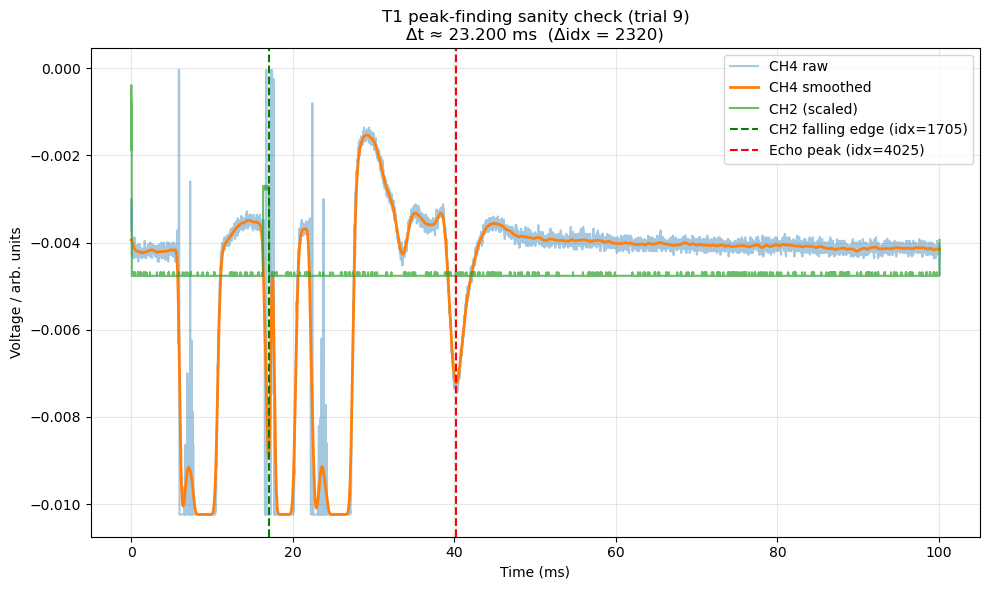

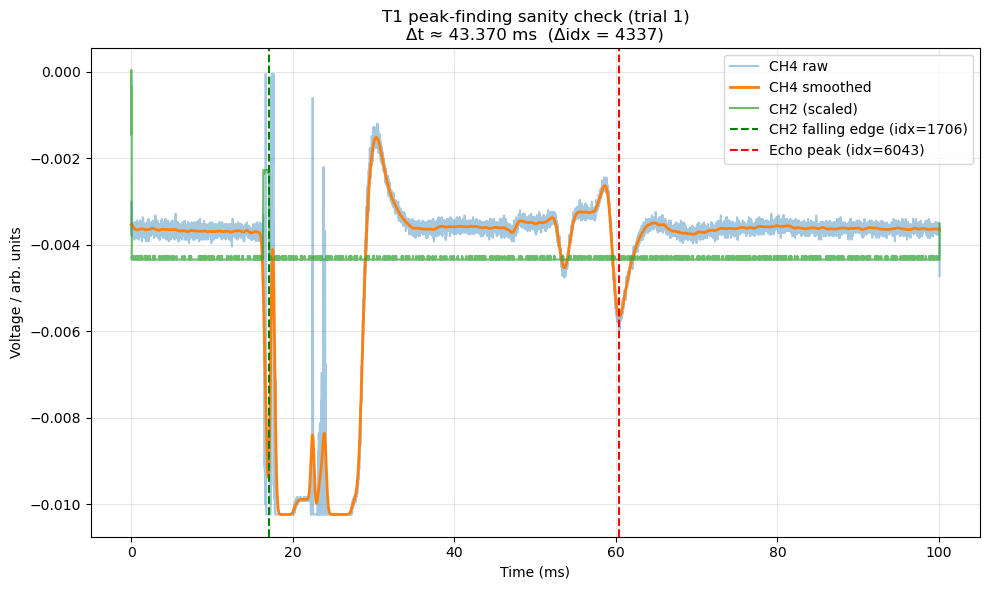

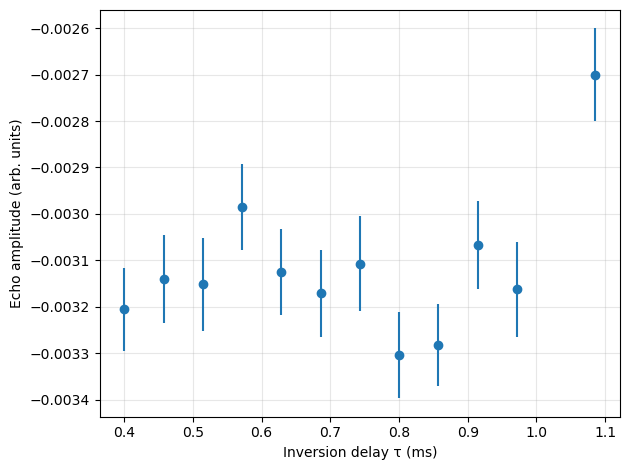

/var/folders/p2/_g31cvgx6g10vhh39s62ls100000gn/T/ipykernel_82894/3391493114.py:304: RuntimeWarning: invalid value encountered in sqrt
  M_inf_unc, dM_unc, T1_unc = np.sqrt(np.diag(pcov))


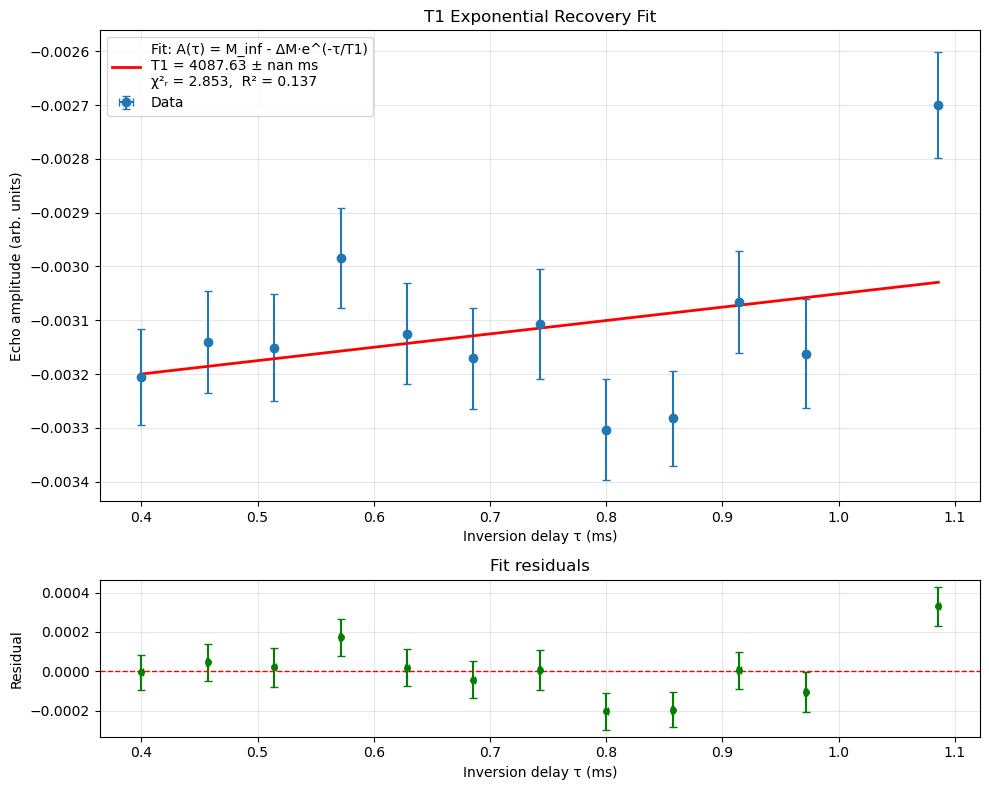

T1 fit results:
  M_inf = 1.01329 ± nan
  ΔM    = 1.01659 ± nan
  T1    = 4.08763 ± nan s  (4.09e+03 ± nan ms)
  Reduced χ² = 2.853163
  R²         = 0.137359


In [19]:
# 1) Basic sanity checks on timing / peak finding
plot_min_max_t1_peak_finding(t1_df)        # min & max delay trials

# 2) Quick amplitude vs delay scatter with error bars
tau, tau_err, amp, amp_err = build_t1_arrays(t1_df)
plt.errorbar(tau*1e3, amp, xerr=tau_err*1e3, yerr=amp_err, fmt='o')
plt.xlabel("Inversion delay τ (ms)")
plt.ylabel("Echo amplitude (arb. units)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Full T1 fit
T1_fit, T1_unc, chi2_red = find_t1(t1_df, plot=True)


In [20]:
from pathlib import Path

def import_csv_files(file_path, file_beginning):
    """
    Import CSV files matching a pattern with an optional 'T1' prefix, then
    <file_beginning>, then 'M' followed by a numeric value.

    Examples matched:
      T1CuM1.00e-01.csv   (T1 data, Cu)
      CuM1.00e-01.csv     (T2 data, Cu)

    Parameters
    ----------
    file_path : str
        Directory path containing the CSV files
    file_beginning : str
        Middle pattern of the filename (e.g. "Cu", "Fe")

    Returns
    -------
    dict
        { numeric_value : DataFrame }
        where numeric_value is the concentration parsed from the filename.
    """
    file_dict = {}
    path = Path(file_path)

    if not path.exists():
        raise ValueError(f"Directory not found: {file_path}")

    # Pattern: optional 'T1', then file_beginning, then 'M<number>.csv'
    # e.g. T1CuM1.00e-01.csv or CuM1.00e-01.csv
    pattern = re.compile(
        rf"^(?:T1)?{re.escape(file_beginning)}M([\d.]+e[+-]?\d+)\.csv$",
        re.IGNORECASE
    )

    for file in path.iterdir():
        if file.is_file():
            match = pattern.match(file.name)
            if match:
                numeric_str = match.group(1)
                numeric_value = float(numeric_str)
                try:
                    df = pd.read_csv(file)
                    file_dict[numeric_value] = df
                except Exception as e:
                    print(f"Error reading {file.name}: {e}")

    file_dict = dict(sorted(file_dict.items()))

    if not file_dict:
        print(f"No matching CSV files found in {file_path}")
        print(f"Looking for pattern: [T1]{file_beginning}M<number>e<exp>.csv")

    return file_dict


In [21]:
t1_cu_dict = import_csv_files(r"../Pulse_NMR_Code/PHY_451_T1_data", "Cu")
t1_fe_dict = import_csv_files(r"../Pulse_NMR_Code/PHY_451_T1_data", "Fe")


In [ ]:
# T1 Cu
cu_t1_fit = []
for m_value, df in t1_cu_dict.items():
    T1, unc, chi2 = find_t1(df, plot=False)
    cu_t1_fit.append((m_value, T1, unc, chi2))
    print(f'Cu Concentration: {m_value:.4e} \n\tT_1: {T1:.4e} \n\tUnc: {unc:.4e}\n\tRed chi^2: {chi2:.3f}')


Cu Concentration: 4.8000e-02 
	T_1: 3.4885e+00 
	Unc: nan
	Red chi^2: 7.546
Cu Concentration: 8.0000e-02 
	T_1: 4.3253e+00 
	Unc: nan
	Red chi^2: 8.397
Cu Concentration: 1.0000e-01 
	T_1: 4.0876e+00 
	Unc: nan
	Red chi^2: 2.853
Cu Concentration: 1.6000e-01 
	T_1: 6.7970e+00 
	Unc: nan
	Red chi^2: 3.038
Cu Concentration: 2.5000e-01 
	T_1: 3.3139e+00 
	Unc: 3.8021e+03
	Red chi^2: 3.600
Cu Concentration: 3.2000e-01 
	T_1: 3.8449e+00 
	Unc: 2.1473e+03
	Red chi^2: 1.177
Cu Concentration: 4.8000e-01 
	T_1: 2.7373e+00 
	Unc: 4.1417e+03
	Red chi^2: 0.770
Cu Concentration: 6.6000e-01 
	T_1: 1.6489e+00 
	Unc: 1.7571e+03
	Red chi^2: 0.245
Cu Concentration: 7.5000e-01 
	T_1: 5.2711e-02 
	Unc: 3.5051e+00
	Red chi^2: 0.243


/var/folders/p2/_g31cvgx6g10vhh39s62ls100000gn/T/ipykernel_82894/3391493114.py:304: RuntimeWarning: invalid value encountered in sqrt
  M_inf_unc, dM_unc, T1_unc = np.sqrt(np.diag(pcov))


In [24]:
fe_t1_fit = []
for m_value, df in t1_fe_dict.items():
    T1, unc, chi2 = find_t1(df, plot=False)
    fe_t1_fit.append((m_value, T1, unc, chi2))
    print(f'Fe Concentration: {m_value:.4e} \n\tT_1: {T1:.4e} \n\tUnc: {unc:.4e}\n\tRed chi^2: {chi2:.3f}')


Fe Concentration: 2.5000e-03 
	T_1: 6.1104e-04 
	Unc: 3.1841e-02
	Red chi^2: 0.165
Fe Concentration: 5.0000e-03 
	T_1: 3.2197e-03 
	Unc: 6.2847e-02
	Red chi^2: 0.288
Fe Concentration: 1.0000e-02 
	T_1: 5.8471e+00 
	Unc: 1.4005e+04
	Red chi^2: 4.904


/var/folders/p2/_g31cvgx6g10vhh39s62ls100000gn/T/ipykernel_82894/3391493114.py:304: RuntimeWarning: invalid value encountered in sqrt
  M_inf_unc, dM_unc, T1_unc = np.sqrt(np.diag(pcov))


Fe Concentration: 1.5000e-02 
	T_1: 5.4940e+00 
	Unc: nan
	Red chi^2: 0.238
Fe Concentration: 2.5000e-02 
	T_1: 3.4435e-03 
	Unc: 1.1140e-02
	Red chi^2: 0.186
Fe Concentration: 3.0000e-02 
	T_1: 1.3247e+00 
	Unc: 2.1186e+03
	Red chi^2: 0.261
Fe Concentration: 4.0000e-02 
	T_1: 5.7435e-03 
	Unc: 2.7220e-02
	Red chi^2: 0.414
Fe Concentration: 5.0000e-02 
	T_1: 1.2601e-03 
	Unc: 2.3310e-03
	Red chi^2: 0.035


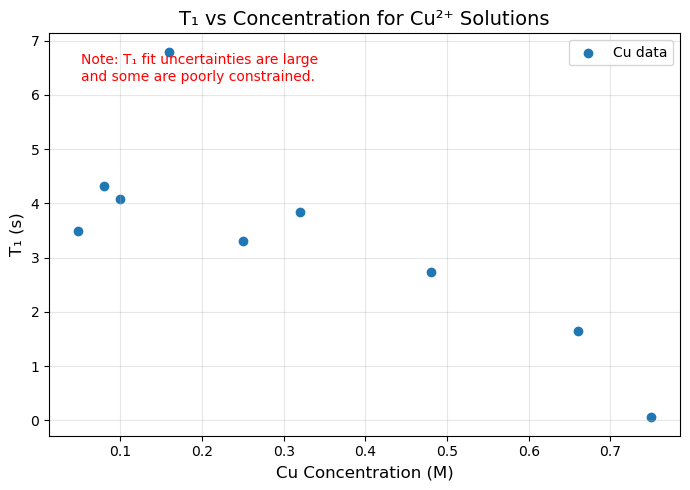

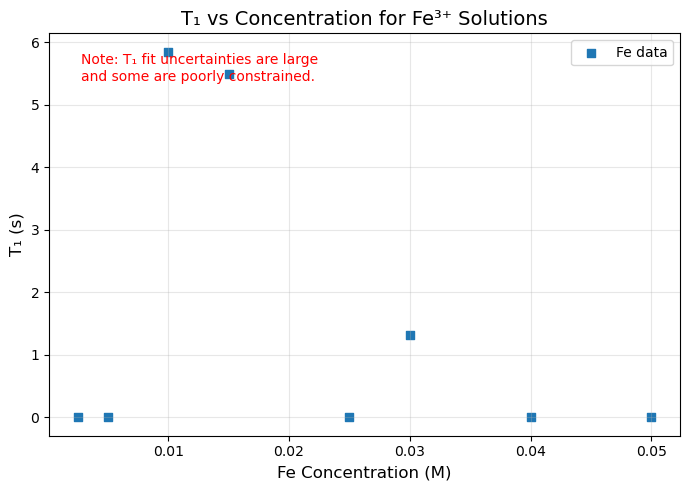

In [27]:
# Convert fit results to arrays
cu_t1_fit = np.asarray(cu_t1_fit)   # shape (N_cu, 4): [M, T1, unc, chi2]
fe_t1_fit = np.asarray(fe_t1_fit)   # shape (N_fe, 4): [M, T1, unc, chi2]

# Unpack Cu
cu_M      = cu_t1_fit[:, 0]
cu_T1     = cu_t1_fit[:, 1]
cu_T1_unc = cu_t1_fit[:, 2]

# Unpack Fe
fe_M      = fe_t1_fit[:, 0]
fe_T1     = fe_t1_fit[:, 1]
fe_T1_unc = fe_t1_fit[:, 2]

# -------------------------------------------------
# Plot 1: Cu – concentration vs T1 (no error bars)
# -------------------------------------------------
plt.figure(figsize=(7,5))
plt.scatter(cu_M, cu_T1, marker='o', label='Cu data')
plt.xlabel('Cu Concentration (M)', fontsize=12)
plt.ylabel('T₁ (s)', fontsize=12)
plt.title('T₁ vs Concentration for Cu²⁺ Solutions', fontsize=14)
plt.grid(True, which='both', alpha=0.3)
plt.legend()

# Note about uncertainties (in axes coordinates)
plt.text(
    0.05, 0.95,
    "Note: T₁ fit uncertainties are large\nand some are poorly constrained.",
    transform=plt.gca().transAxes,
    va='top', ha='left',
    fontsize=10, color='red'
)

plt.tight_layout()
plt.show()

# -------------------------------------------------
# Plot 2: Fe – concentration vs T1 (no error bars)
# -------------------------------------------------
plt.figure(figsize=(7,5))
plt.scatter(fe_M, fe_T1, marker='s', label='Fe data')
plt.xlabel('Fe Concentration (M)', fontsize=12)
plt.ylabel('T₁ (s)', fontsize=12)
plt.title('T₁ vs Concentration for Fe³⁺ Solutions', fontsize=14)
plt.grid(True, which='both', alpha=0.3)
plt.legend()

plt.text(
    0.05, 0.95,
    "Note: T₁ fit uncertainties are large\nand some are poorly constrained.",
    transform=plt.gca().transAxes,
    va='top', ha='left',
    fontsize=10, color='red'
)

plt.tight_layout()
plt.show()

# Example Tests

In [9]:
def plot_t1_peak_finding(df: pd.DataFrame, idx: int, time_scale: float = 1e-5):
    """
    Sanity check plot for T1:
      - Shows CH2 (pulses) and CH4 (echo)
      - Marks CH2 'falling edge' and CH4 echo peak
      - Displays Δt from those two points

    df  : T1 dataframe (4 channels per trial)
    idx : trial index (0-based)
    """
    # Grab channels for this trial
    ch2 = df.iloc[:, 4*idx + 1].to_numpy()
    ch4 = df.iloc[:, 4*idx + 3].to_numpy()

    # --- Reproduce the same logic as find_delta_t ---
    smoothed = scipy.ndimage.gaussian_filter(ch4, 20)
    drange = np.max(smoothed) - np.min(smoothed)

    filter_start = smoothed.shape[0] - np.argmin(smoothed[::-1])

    # Find echo peak in CH4
    min_prom = drange * 0.02
    max_prom = drange * 0.8
    for _ in range(100):
        prominence = (min_prom, max_prom)
        peaks, _ = scipy.signal.find_peaks(-smoothed[filter_start:], prominence=prominence)
        if len(peaks) == 1:
            break
        elif len(peaks) > 1:
            min_prom = min_prom + (max_prom - min_prom) * 0.1
        else:
            min_prom = min_prom * 0.5
        if min_prom >= max_prom:
            raise ValueError("Cannot find exactly 1 peak with valid prominence range")
    else:
        print("Warning: Failed to find exactly 1 peak after maximum iterations")
        return

    echo_peak_idx = peaks[0] + filter_start

    # Find falling edge of CH2
    mask = ch2 > (np.min(ch2) + drange * 0.05)
    filter_idx = np.argwhere(ch2 == np.median(ch2[mask]))[-1][0]

    delta_idx = echo_peak_idx - filter_idx
    delta_t = delta_idx * time_scale   # in seconds

    # --- Build time axis ---
    t = np.arange(len(ch4)) * time_scale  # seconds

    # --- Plot ---
    plt.figure(figsize=(10,6))

    # CH4 raw + smoothed
    plt.plot(t*1e3, ch4, label="CH4 raw", alpha=0.4)
    plt.plot(t*1e3, smoothed, label="CH4 smoothed", linewidth=2)

    # CH2 (scaled to overlay roughly)
    ch2_scaled = (ch2 - np.mean(ch2))
    ch2_scaled = ch2_scaled / np.max(np.abs(ch2_scaled)) * (0.5*drange)
    plt.plot(t*1e3, ch2_scaled + np.mean(smoothed), label="CH2 (scaled)", alpha=0.7)

    # Vertical lines for falling edge & peak
    plt.axvline(t[filter_idx]*1e3, color='green', linestyle='--',
                label=f"CH2 falling edge (idx={filter_idx})")
    plt.axvline(t[echo_peak_idx]*1e3, color='red', linestyle='--',
                label=f"Echo peak (idx={echo_peak_idx})")

    plt.title(f"T1 peak-finding sanity check (trial {idx})\n"
              f"Δt ≈ {delta_t*1e3:.3f} ms  (Δidx = {delta_idx})")
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage / arb. units")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


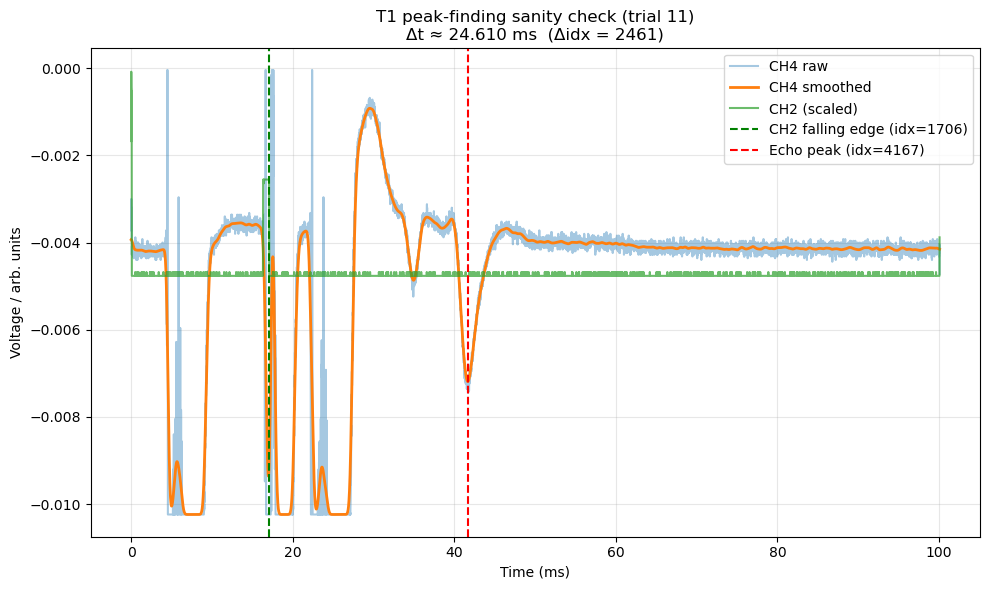

In [12]:
t1_df = pd.read_csv("../Pulse_NMr_Code/PHY_451_T1_data/T1CuM1.00e-01.csv")
plot_t1_peak_finding(t1_df, idx=11)

All delays (s): [0.00091429 0.0012     0.0010857  0.00062857 0.0010286  0.0008
 0.00097143 0.00068571 0.00057143 0.0004     0.00085714 0.00045714
 0.00051429 0.0011429  0.00074286        nan]
Min delay:  idx=9, τ = 0.400 ms
Max delay:  idx=1, τ = 1.200 ms


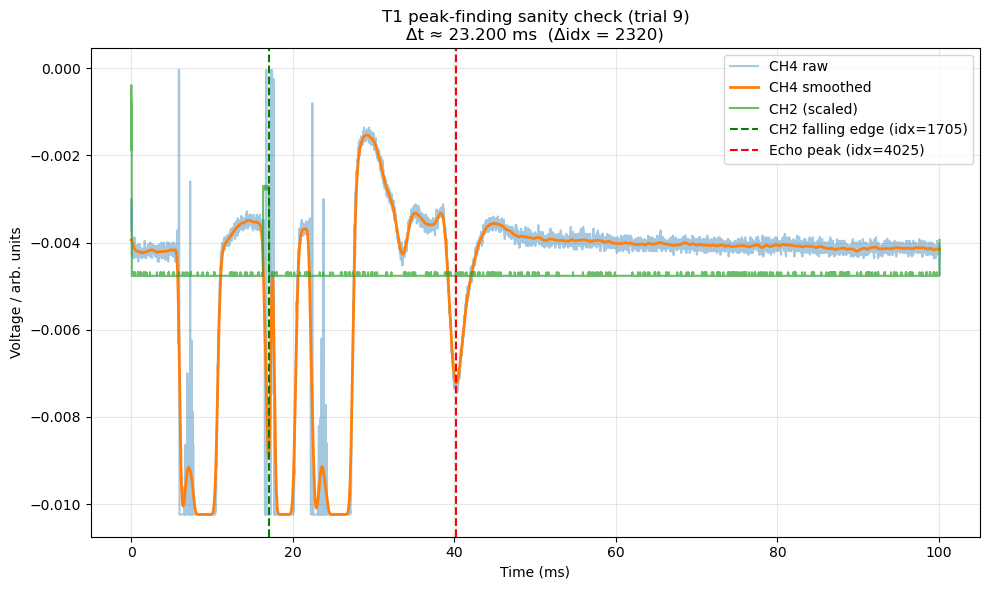

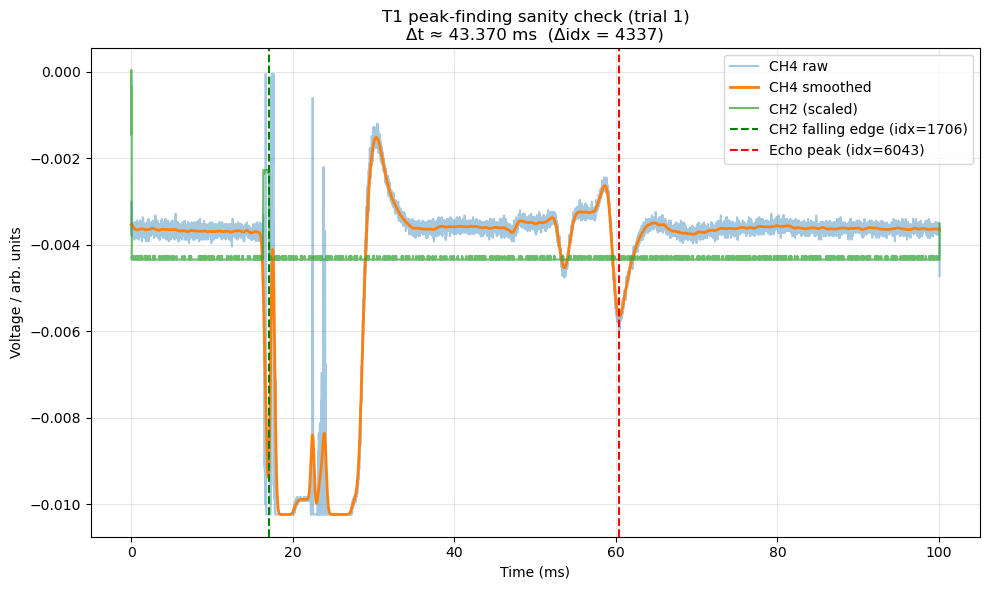

In [15]:
# Find all inversion delays from column names
delays = get_unique_delta_times(t1_df)   # in seconds
print("All delays (s):", delays)

# Mask out NaNs
valid_mask = ~np.isnan(delays)
valid_delays = delays[valid_mask]

# Indices in the *full* array corresponding to min/max of the valid ones
min_idx = np.where(valid_mask)[0][np.argmin(valid_delays)]
max_idx = np.where(valid_mask)[0][np.argmax(valid_delays)]
min_delay = delays[min_idx]
max_delay = delays[max_idx]

print(f"Min delay:  idx={min_idx}, τ = {min_delay*1e3:.3f} ms")
print(f"Max delay:  idx={max_idx}, τ = {max_delay*1e3:.3f} ms")

# Plot sanity-check peak finding for these two
plot_t1_peak_finding(t1_df, idx=min_idx)
plot_t1_peak_finding(t1_df, idx=max_idx)
